In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Creating training and testing datsets**

###### The initial dataset is not achieved in the format we are using in this research notebook. One can use their own code to shift files in the format assumed in this research notebook

***(Kindly go through the Readme file for more details)***




In [ ]:
# We will use the prebuilt Segmentation models library, which provides several pretrained models, and custom losses and metrics 
# important for a problem statemtn like this 
!pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-7z491c5f
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-7z491c5f
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 50 kB 8.1 MB/s 
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-py3-none-any.whl size=33809 sha256=d827b6c25a106096d2f39ce69617792a694ee033b5626332c567dc68dadb3583
  Stored in directory: /tmp/pip-ephem-wheel-cache-kyoc44r1/wheels/02/cd/18/61c0bbb8766acfec68f9d20618886b7b38dfeeb95865b6ba00
Successfully built segmentation-models


In [ ]:
# Importing all the necessary libraries

import shutil
from glob import glob
import os
import re
import cv2
import random
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers
from keras.layers import *  
from keras.models import Model
from keras import backend as K
from matplotlib import pyplot as plt
from keras.optimizers import Adam, SGD
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

In [ ]:
import keras

In [ ]:
print(keras.__version__)

2.5.0


In [ ]:
# Importing the pre-trained segmentation_models library
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [ ]:
# Initializing the necessary variables

SEED = 1
BATCH_SIZE = 4  #... Keeping the Batch_size low, to avoid Resource-allocation OOM error 
IMG_SIZE = 512  #... Using image size close to the initial image_size
N_CHANNELS = 3
N_CLASSES = 1   #... The final output ranges between 0-1
lr_init = 0.0001
EPOCHS = 20
THRESHOLD = 0.5

### **Dataloader (stacking the tensors)**


In [ ]:
## Creating training dataset

final_masks_list = []
final_images_list = []
non_zero_images = []

train_masks_list = glob("/content/drive/MyDrive/CT_SCANS_DATASET/train_masks/" + "*.jpg")  # list of all training mask-paths


for mask_path in train_masks_list:

  """ Mask is read and resized """
  mask = tf.io.read_file(mask_path)
  mask = tf.image.decode_png(mask, channels=1)
  mask = mask/255    #... To keep the mask values as either 0s or 1s (initially as 0s and 255s)
  mask = tf.image.resize(mask, [IMG_SIZE, IMG_SIZE])

  """ The image path is like: - "/content/drive/MyDrive/CT_SCANS_DATASET/train_image/XX.jpg"
      The mask path is like: - "/content/drive/MyDrive/CT_SCANS_DATASET/train_masks/XX_HGE_Seg.jpg" """
  
  image_path = re.sub("_HGE_Seg", "", mask_path)
  image_path = re.sub("train_masks", "train_images", image_path)

  # list of image paths who have a segmentation masks
  non_zero_images.append(image_path)
  
  """ Image is read and resized """
  image = cv2.imread(image_path)
  image = image/255
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  image = tf.cast(image, tf.float32)

  # These lists will be used to stack as training and testing datasets
  final_images_list.append(image)
  final_masks_list.append(mask)

# To create a more balanced dataset of images with hemmorage and ones with not, we find out those 
# image paths with no masks, and create their masks as 0s.
arr1 = np.setdiff1d(np.asarray(glob("/content/drive/MyDrive/CT_SCANS_DATASET/train_images/" + "*.jpg")), np.asarray(non_zero_images))
np.random.seed(SEED)
np.random.shuffle(arr1)

# Now, we will use a ratio of 1:2 for images with and without masks
for image_path in arr1[:2*len(train_masks_list)]:
  
  # Reading and resizing the images
  image = tf.io.read_file(image_path)
  image = tf.image.decode_png(image, channels=3)
  image = image/255
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  
  # Creating a mask with all values as 0s
  mask = tf.zeros((image.shape[0], image.shape[1], 1))
  
  final_masks_list.append(mask)
  final_images_list.append(image)

# Stacking the images and the masks as training data tensors
X_train = tf.stack(final_images_list, axis=0)
Y_train = tf.stack(final_masks_list, axis=0)

del final_images_list  #... Deleting the lists, as they 
del final_masks_list   #... aquire unecessary space

print(X_train.shape)
print(Y_train.shape)

(780, 512, 512, 3)
(780, 512, 512, 1)


###### That is, in training data, only 260 images have a hemorrhage associated to it. To manage this imbalance, only a fraction of images are selected with no segmentation masks (260 + 520) [1:2] as training data

In [ ]:
## Creating validation dataset

""" Doing the same to create validation datset """ 

final_masks_list = []
final_images_list = []
non_zero_images = []

val_masks_list = glob("/content/drive/MyDrive/CT_SCANS_DATASET/val_masks/" + "*.jpg")

for mask_path in val_masks_list:

  mask = tf.io.read_file(mask_path)
  mask = tf.image.decode_png(mask, channels=1)
  mask = mask/255
  mask = tf.image.resize(mask, [IMG_SIZE, IMG_SIZE])
  final_masks_list.append(mask)

  image_path = re.sub("_HGE_Seg", "", mask_path)
  image_path = re.sub("val_masks", "val_images", image_path)

  non_zero_images.append(image_path)
  
  image = cv2.imread(image_path)
  image = image/255
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  image = tf.cast(image, tf.float32)
  final_images_list.append(image)

arr1 = np.setdiff1d(np.asarray(glob("/content/drive/MyDrive/CT_SCANS_DATASET/val_images/" + "*.jpg")), np.asarray(non_zero_images))
np.random.seed(SEED)
np.random.shuffle(arr1)

for image_path in arr1[:len(val_masks_list)]:
  image = tf.io.read_file(image_path)
  image = tf.image.decode_png(image, channels=3)
  image = image/255
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  final_images_list.append(image)

  mask = tf.zeros((image.shape[0], image.shape[1], 1))
  final_masks_list.append(mask)


X_val = tf.stack(final_images_list, axis=0)
Y_val = tf.stack(final_masks_list, axis=0)

del final_images_list
del final_masks_list

print(X_val.shape)
print(Y_val.shape)

(54, 512, 512, 3)
(54, 512, 512, 1)


### **Visualizing the the training images**

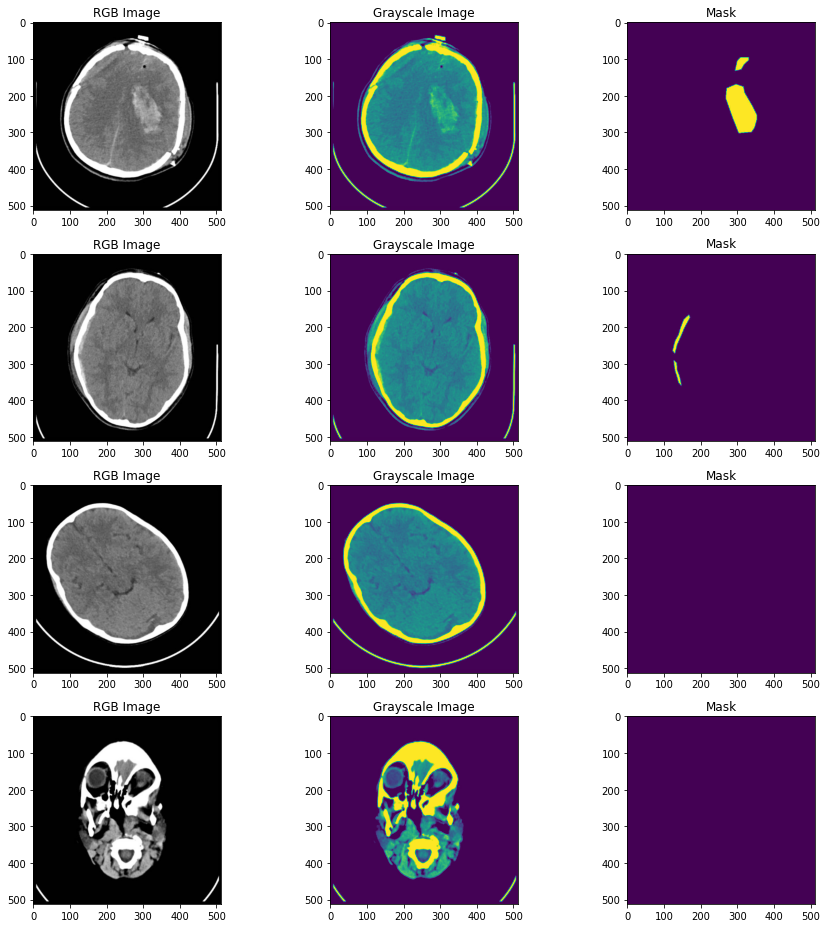

In [ ]:
idx = [5, 17, 270, 275]   # The indexes contain 2 images with hemorrhages, and two without them 

fig, axs = plt.subplots(nrows = 4, ncols = 3)


fig.set_figheight(13)
fig.set_figwidth(13)


for i in range(len(idx)):

  image_1 = X_train[idx[i], :, :, :]
  image_2 = tf.image.rgb_to_grayscale(image_1)
  mask = Y_train[idx[i], :, :, :]

  axs[i][0].imshow(image_1)
  axs[i][0].set_title("RGB Image")

  axs[i][1].imshow(tf.squeeze(image_2, axis=-1))
  axs[i][1].set_title("Grayscale Image")

  axs[i][2].imshow(tf.squeeze(mask, axis=-1))
  axs[i][2].set_title("Mask")

plt.tight_layout()
plt.show()

### **Image-Augmentation using ImageDataGenerator**

In [ ]:
""" Since the dataset size is very low, we will have to use image augmentation to incorporate it """

data_gen_args = dict(rotation_range=90, width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.2)

# Creating 2 instances of generator to fit on images and masks separately
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# We will need to provide the same seed and keyword arguments to the fit and flow methods
image_datagen.fit(X_train, augment=True, seed= SEED)
mask_datagen.fit(Y_train, augment=True, seed=SEED)

image_generator = image_datagen.flow(X_train, batch_size = BATCH_SIZE, seed=SEED)
mask_generator = mask_datagen.flow(Y_train, batch_size = BATCH_SIZE, seed=SEED)

# combine generators into one which yields image and masks together. This will be used in model.fit
train_generator = zip(image_generator, mask_generator)

""" For more info, visit "https://keras.io/api/preprocessing/image/" """

' For more info, visit "https://keras.io/api/preprocessing/image/" '

## **Visualizing the Augmented images**

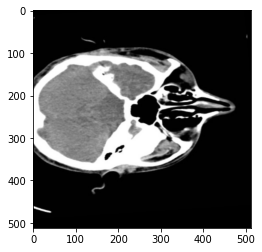

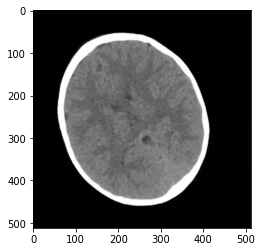

In [ ]:
# A small piece of code to visualize the augmented images from the training set
x = next(image_generator)
for i in range(2):
  plt.imshow(x[i])
  plt.show()

## **Model initialization, and training**

In [ ]:
# Using a basic Adam Optimizer for training
optimizer = tf.keras.optimizers.Adam(0.0001)

# Using Dice-loss, and focal loss to incorporate for class-imbalance (Available in segmentation models library)
dice_loss = sm.losses.DiceLoss(beta=2) 
focal_loss = sm.losses.BinaryFocalLoss()

# Giving the focal loss, a higher weightage to train on due to severe class imbalance
total_loss = dice_loss + (2 * focal_loss)

# Both IOU as well as F-Score are used as metrics to judge the performance
metrics = [sm.metrics.IOUScore(threshold=0.5, name="iou"), sm.metrics.FScore(threshold=0.5, name="fscore")]

In [ ]:
# Defining a simple Leraning rate scheduler function

lr_init = 0.0001
def scheduler_3(epoch):
    if epoch == 0:
        return lr_init
    else:
        return lr_init*((1-epoch/100)**0.9)

In [ ]:
# Set of callbacks applied on the model training 
scheduler = LearningRateScheduler(scheduler_3, verbose=1)
earlystop = EarlyStopping(monitor='val_iou',mode='max',verbose=1,patience=10,restore_best_weights=True)
checkpoint = ModelCheckpoint('temp_Unet',save_weights_only=True,monitor='val_iou',mode='max',save_best_only=True)

In [ ]:
# We hope to use a U-net model with resnet-34 backbone, to train on 

BACKBONE_1 = "vgg16"
model1 = sm.Unet(BACKBONE_1, encoder_weights='imagenet', classes=1, activation="sigmoid")
model1.compile(optimizer, total_loss, metrics)

### **Note: -**

##### You might face an error while trying to compile the pretrained model, (**module 'keras.utils' has no attribute 'get_file'**). That seems to be an error in the library, possibly due to verion differences in several other libraries we used (Tensorflow, keras etc.). I have added a temporary solution to the issue in the **Readme** file. Do check that out

In [ ]:
# Visualizing the model architecture
model1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 6 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, None, None, 6 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, None, None, 6 0           block1_conv2[0][0]               
______________________________________________________________________________________________

In [ ]:
# Model training 
""" To prevent excess use of GPU on colab, I have trained the model for 40-epochs 
    [We will see further, the loss and IOU flattens out at 40 or so epochs] """

TRAINING_SIZE = X_train.shape[0]
model1_history = model1.fit(train_generator, epochs = EPOCHS,
                          steps_per_epoch = TRAINING_SIZE // BATCH_SIZE,
                          validation_data = (X_val, Y_val),
                          callbacks = [scheduler, earlystop, checkpoint])

Epoch 1/20

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
97/97 [==============================] - 98s 957ms/step - loss: 0.6133 - iou: 0.2618 - fscore: 0.3759 - val_loss: 0.7575 - val_iou: 0.1747 - val_fscore: 0.2589
Epoch 2/20

Epoch 00002: LearningRateScheduler reducing learning rate to 9.909954834128343e-05.
97/97 [==============================] - 93s 964ms/step - loss: 0.6254 - iou: 0.2444 - fscore: 0.3525 - val_loss: 0.6801 - val_iou: 0.1814 - val_fscore: 0.2662
Epoch 3/20

Epoch 00003: LearningRateScheduler reducing learning rate to 9.819818665965754e-05.
97/97 [==============================] - 95s 983ms/step - loss: 0.5267 - iou: 0.3288 - fscore: 0.4506 - val_loss: 0.7739 - val_iou: 0.1329 - val_fscore: 0.2099
Epoch 4/20

Epoch 00004: LearningRateScheduler reducing learning rate to 9.729590473501306e-05.
97/97 [==============================] - 95s 976ms/step - loss: 0.5184 - iou: 0.3130 - fscore: 0.4368 - val_loss: 0.6317 - val_iou: 0.2580 - val_fscore

In [ ]:
# Plloting the loss functions

plt.plot(model1_history.history["loss"], 'b')
plt.plot(model1_history.history["val_loss"], 'r')
plt.title("Total Loss (Train and Val)")
plt.legend(["train loss", "val loss"])
plt.show()

plt.plot(model1_history.history["iou"], 'b')
plt.plot(model1_history.history["val_iou"], 'r')
plt.title("IOU (Train and Val)")
plt.legend(["train IOU", "val IOU"])
plt.show()

In [ ]:
# from keras.models import load_model
# model1.save('/content/brain_hemorrh_vgg16_backbone_1.hdf5')
model1 = load_model('/content/brain_hemorrh_vgg16_backbone_1.hdf5', compile = False)

In [ ]:
shutil.move("/content/brain_hemorrh_resnet34_backbone.hdf5", "/content/drive/MyDrive")

'/content/drive/MyDrive/incep_backbone_1.hdf5'

## **Plotting the results**

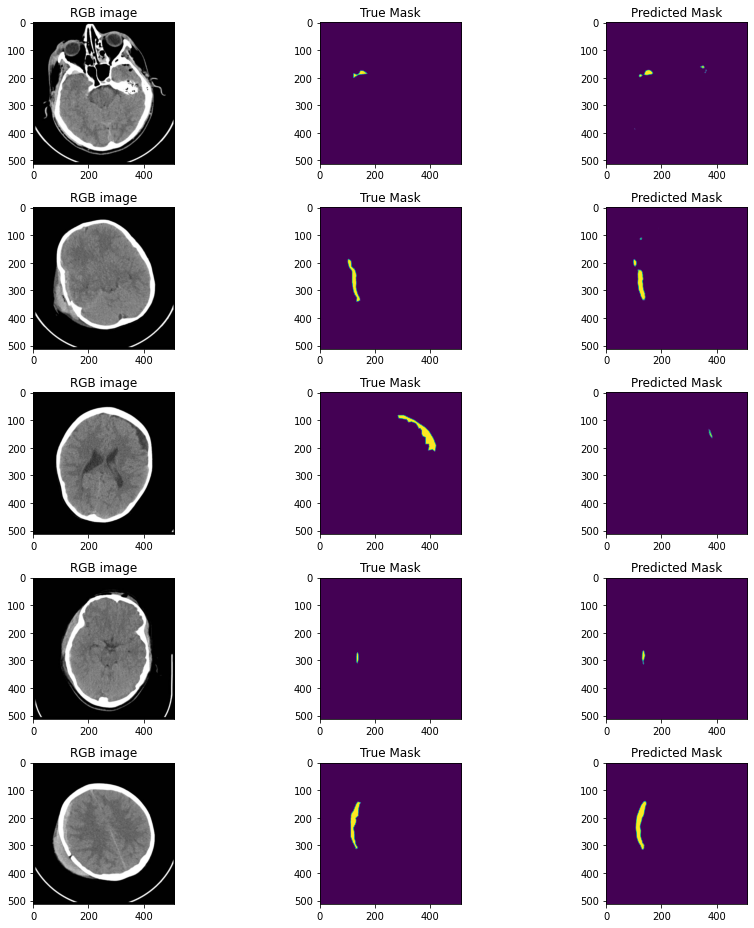

In [ ]:
# Plotting the predictions of the model

""" Using all images with hemorrhages """

mask_path_1 = "/content/drive/MyDrive/CT_SCANS_DATASET/test_masks/049_14_HGE_Seg.jpg"
mask_path_2 = "/content/drive/MyDrive/CT_SCANS_DATASET/test_masks/051_16_HGE_Seg.jpg"
mask_path_3 = "/content/drive/MyDrive/CT_SCANS_DATASET/test_masks/070_23_HGE_Seg.jpg"
mask_path_4 = "/content/drive/MyDrive/CT_SCANS_DATASET/test_masks/089_17_HGE_Seg.jpg"
mask_path_5 = "/content/drive/MyDrive/CT_SCANS_DATASET/test_masks/051_24_HGE_Seg.jpg"

mask_path_list = [mask_path_1, mask_path_2, mask_path_3, mask_path_4, mask_path_5]

fig, axs = plt.subplots(nrows = 5, ncols = 3)

fig.set_figheight(13)
fig.set_figwidth(13)

for i in range(len(mask_path_list)):

  # Image
  image_path = re.sub("test_masks", "test_images", mask_path_list[i])
  image_path = re.sub("_HGE_Seg", "", image_path)
  image = cv2.imread(image_path)
  image = image/255
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])

  axs[i][0].imshow(image)
  axs[i][0].set_title("RGB image")

  # True mask
  mask = tf.io.read_file(mask_path_list[i])
  mask = tf.image.decode_png(mask, channels=1)
  mask = tf.image.resize(mask, [IMG_SIZE, IMG_SIZE])
  mask = tf.squeeze(mask, axis=-1)
  mask = mask/255

  axs[i][1].imshow(mask)
  axs[i][1].set_title("True Mask")

  # Predicted Mask
  predict = model1.predict(tf.expand_dims(image, axis=0))

  axs[i][2].imshow(tf.squeeze(tf.squeeze(predict, axis=-1), axis=0))
  axs[i][2].set_title("Predicted Mask")
  

plt.tight_layout()
plt.show()

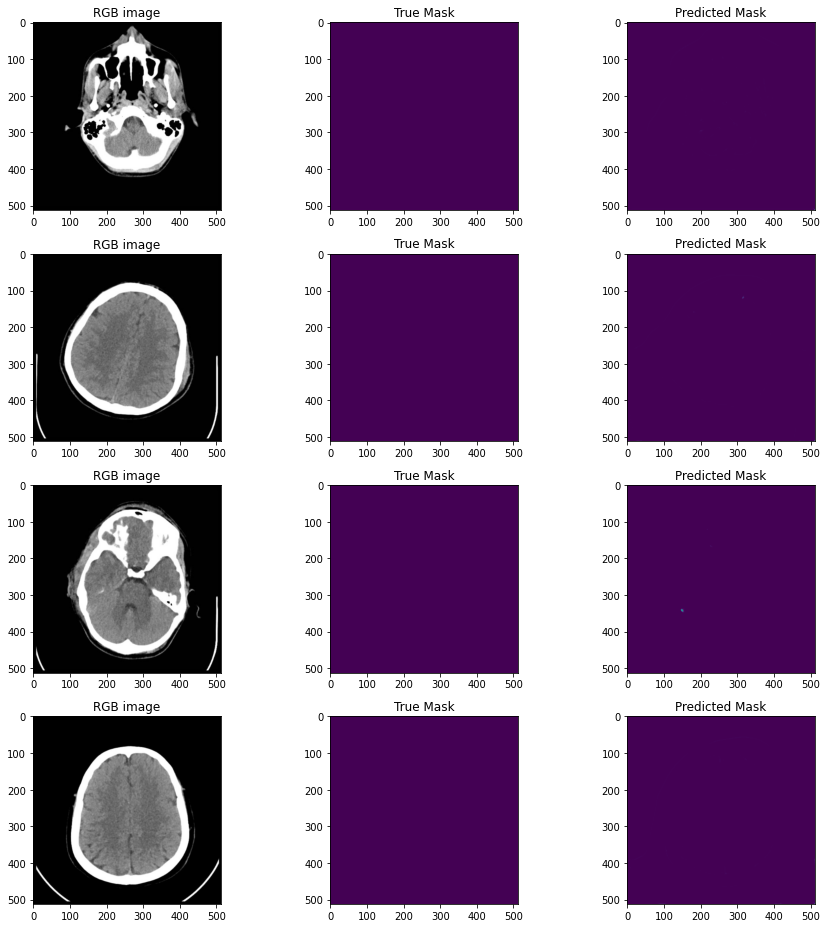

In [ ]:
# Plotting the predictions of the model

""" Using all images with no hemorrhages """

img_path_1 = "/content/drive/MyDrive/CT_SCANS_DATASET/test_images/065_5.jpg"
img_path_2 = "/content/drive/MyDrive/CT_SCANS_DATASET/test_images/083_25.jpg"

img_path_3 = "/content/drive/MyDrive/CT_SCANS_DATASET/test_images/089_15.jpg"
img_path_4 = "/content/drive/MyDrive/CT_SCANS_DATASET/test_images/102_24.jpg"

img_path_list = [img_path_1, img_path_2, img_path_3, img_path_4]

fig, axs = plt.subplots(nrows = 4, ncols = 3)

fig.set_figheight(13)
fig.set_figwidth(13)

for i in range(len(img_path_list)):

  # Image
  image_path = img_path_list[i]
  image = cv2.imread(image_path)
  image = image/255
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])

  axs[i][0].imshow(image)
  axs[i][0].set_title("RGB image")

  # True mask

  mask = tf.zeros((IMG_SIZE, IMG_SIZE))
  axs[i][1].imshow(mask)
  axs[i][1].set_title("True Mask")

  # Predicted Mask
  predict = model1.predict(tf.expand_dims(image, axis=0))

  axs[i][2].imshow(tf.squeeze(tf.squeeze(predict, axis=-1), axis=0))
  axs[i][2].set_title("Predicted Mask")
  

plt.tight_layout()
plt.show()

# **Soft-Attention based UNet**



##### In the next section, I have attempted an implementation of a **Soft-attention based U-Net model**, with the same **VGG-16** backbone as earlier. The intuition behind this being the fact that attention modules play a very significant role in medical image analysis.
 
##### **Attention layers** in architectures help them to focus on certain key-aspects of images, which inturn are decisive features in image analysis. Such trainable layers optimize to assign higher weights to sections of images with higher importance. The sigmoidal outputs of these layers (called **attention coefficients**) when multiplied to the feature maps, increase numerical values of section with higher importance

## **1) Writting a Soft-attention based U-Net from scratch**

#### Attention blocks in a general sense are attached in the concatenation section of the U-Net architecture, with two passes as gating signal and attention block.



1.   ### **Gatting Signal**: - 
      These Signals are applied on the smaller sized feature map, with generally a Convolution and a batch-normalization layer
2.   ### **Attention Block**: - 
      These are applied on both the output of the lower layer, as well as the to be concatenated output from the encoder section of the architecture. Usually it props out the attention coeffs, which are upsampled to the original size, and multiplied to the concatenation output, generating the attention based feature-map. Now this feature map is concatenated to the decoder section of the model

*To Understand these concepts better, one must read about the soft-attention mechanism, as it is heavily used in several tasks as image recognition, segmentation and GANs etc.*

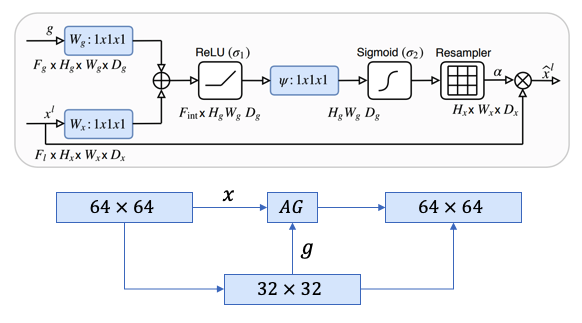

##### The above Figure is reresenting a typical attention layer, where **X** is the output of the to be concatenated layer, and **G** is the output of the layer just below upsampling. The output from the layer **g** is passed firstly through a gating signal, which just adds a convolutional layer. Then, its output combined with the to be concatenated layer is passed through the attention gate, which results in attention coefficiencts, which are multiplied to the to be concatenated layer. This results in the feature map to be scaled by the attention coefficients. 

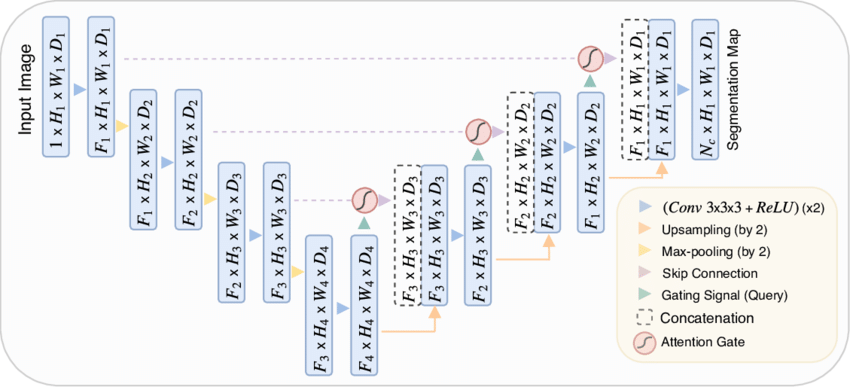

##### These attention layers are attached at every upsamping portion, where the previous layer outputs are oncatenated, after being passed through the attention layers. in the end, we will also to plot those attention coefficients to see if the model is actually learning some attention feature maps

## **2) Pretrained attention Unet on several backbone architectures**

#### I have used a wonderful keras based library, known as **keras-unet-collection**, which have models with weights pre-trained on **Imagenet**. One such architectures here is **att_unet_2d** model

In [ ]:
# To read more about this library, one can visit: -
""" https://github.com/yingkaisha/keras-unet-collection """

!pip install keras-unet-collection

     |████████████████████████████████| 67 kB 4.5 MB/s 


In [ ]:
from keras_unet_collection import models, losses

In [ ]:
model2 = models.att_unet_2d((IMG_SIZE, IMG_SIZE, N_CHANNELS), filter_num=[64, 128, 256, 512, 1024], n_labels=1, stack_num_down=2, stack_num_up=2, activation='ReLU',
                       output_activation='Sigmoid', batch_norm=True, pool=False, backbone='VGG16', weights='imagenet', name='attn_unet')
model2.summary()

/usr/local/lib/python3.7/dist-packages/keras_unet_collection/_backbone_zoo.py:45: UserWarning: 

Backbone VGG16 does not use batch norm, but other layers received batch_norm=True
  warnings.warn(param_mismatch);


58892288/58889256 [==============================] - 0s 0us/step
Model: "attn_unet_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
VGG16_backbone (Functional)     [(None, 512, 512, 64 14714688    input_1[0][0]                    
__________________________________________________________________________________________________
attn_unet_up0_decode_unpool (Up (None, 64, 64, 512)  0           VGG16_backbone[0][4]             
__________________________________________________________________________________________________
attn_unet_up0_att_theta_x (Conv (None, 64, 64, 256)  131328      VGG16_backbone[0][3]             
___________________

In [ ]:
# Here, we have defined a hybrid loss as a sum of focal and dice loss

def hybrid_loss(y_true, y_pred):
  loss_focal = losses.focal_tversky(y_true, y_pred, alpha=0.5, gamma=4/3)
  loss_iou = losses.dice(y_true, y_pred)

  return 2*loss_focal + loss_iou

In [ ]:
model2.compile(loss=hybrid_loss, optimizer = tf.keras.optimizers.Adam(0.0001), metrics = losses.iou_seg)

In [ ]:
TRAINING_SIZE = X_train.shape[0]

"""
  Here we havent used validation data. ON trying to train on collab, I get a resource error while testing each epoch results on validation data
  To avoid this, I have used a very small BATCH_SIZE. Still, as the issue became unavoidable, I elemenated validation data from the training aproach

"""
model2_history = model2.fit(train_generator, epochs = 5,       
                          steps_per_epoch = TRAINING_SIZE // BATCH_SIZE)

Epoch 1/5
195/195 [==============================] - 230s 912ms/step - loss: 2.9429 - iou_seg: 0.9883
Epoch 2/5
195/195 [==============================] - 177s 908ms/step - loss: 2.9033 - iou_seg: 0.9798
Epoch 3/5
195/195 [==============================] - 177s 909ms/step - loss: 2.8669 - iou_seg: 0.9719
Epoch 4/5
195/195 [==============================] - 177s 910ms/step - loss: 2.8149 - iou_seg: 0.9600
Epoch 5/5
195/195 [==============================] - 178s 913ms/step - loss: 2.7335 - iou_seg: 0.9402


In [ ]:
# Plloting the loss functions

plt.plot(model2_history.history["loss"], 'b')
plt.plot(model2_history.history["val_loss"], 'r')
plt.title("Total Loss (Train and Val)")
plt.legend(["train loss", "val loss"])
plt.show()

plt.plot(model2_history.history["iou"], 'b')
plt.plot(model2_history.history["val_iou"], 'r')
plt.title("IOU (Train and Val)")
plt.legend(["train IOU", "val IOU"])
plt.show()

In [ ]:
from keras.models import load_model
model2.save('/content/brain_hemorrh_vgg16_backbone_2.hdf5')
# model2 = load_model('/content/brain_hemorrh_vgg16_backbone_2.hdf5', compile = False)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
shutil.move('/content/brain_hemorrh_vgg16_backbone_2.hdf5', '/content/drive/MyDrive')

'/content/drive/MyDrive/brain_hemorrh_vgg16_backbone_2.hdf5'

In [ ]:
# Plotting the predictions of the model

""" Using all images with hemorrhages """

mask_path_1 = "/content/drive/MyDrive/CT_SCANS_DATASET/test_masks/049_14_HGE_Seg.jpg"
mask_path_2 = "/content/drive/MyDrive/CT_SCANS_DATASET/test_masks/051_16_HGE_Seg.jpg"
mask_path_3 = "/content/drive/MyDrive/CT_SCANS_DATASET/test_masks/070_23_HGE_Seg.jpg"
mask_path_4 = "/content/drive/MyDrive/CT_SCANS_DATASET/test_masks/089_17_HGE_Seg.jpg"
mask_path_5 = "/content/drive/MyDrive/CT_SCANS_DATASET/test_masks/051_24_HGE_Seg.jpg"

mask_path_list = [mask_path_1, mask_path_2, mask_path_3, mask_path_4, mask_path_5]

fig, axs = plt.subplots(nrows = 5, ncols = 3)

fig.set_figheight(13)
fig.set_figwidth(13)

for i in range(len(mask_path_list)):

  # Image
  image_path = re.sub("test_masks", "test_images", mask_path_list[i])
  image_path = re.sub("_HGE_Seg", "", image_path)
  image = cv2.imread(image_path)
  image = image/255
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])

  axs[i][0].imshow(image)
  axs[i][0].set_title("RGB image")

  # True mask
  mask = tf.io.read_file(mask_path_list[i])
  mask = tf.image.decode_png(mask, channels=1)
  mask = tf.image.resize(mask, [IMG_SIZE, IMG_SIZE])
  mask = tf.squeeze(mask, axis=-1)
  mask = mask/255

  axs[i][1].imshow(mask)
  axs[i][1].set_title("True Mask")

  # Predicted Mask
  predict = model2.predict(tf.expand_dims(image, axis=0))
  predict = tf.cast((predict > 0.7), tf.float32)
  
  axs[i][2].imshow(tf.squeeze(tf.squeeze(predict, axis=-1), axis=0))
  axs[i][2].set_title("Predicted Mask")
  

plt.tight_layout()
plt.show()

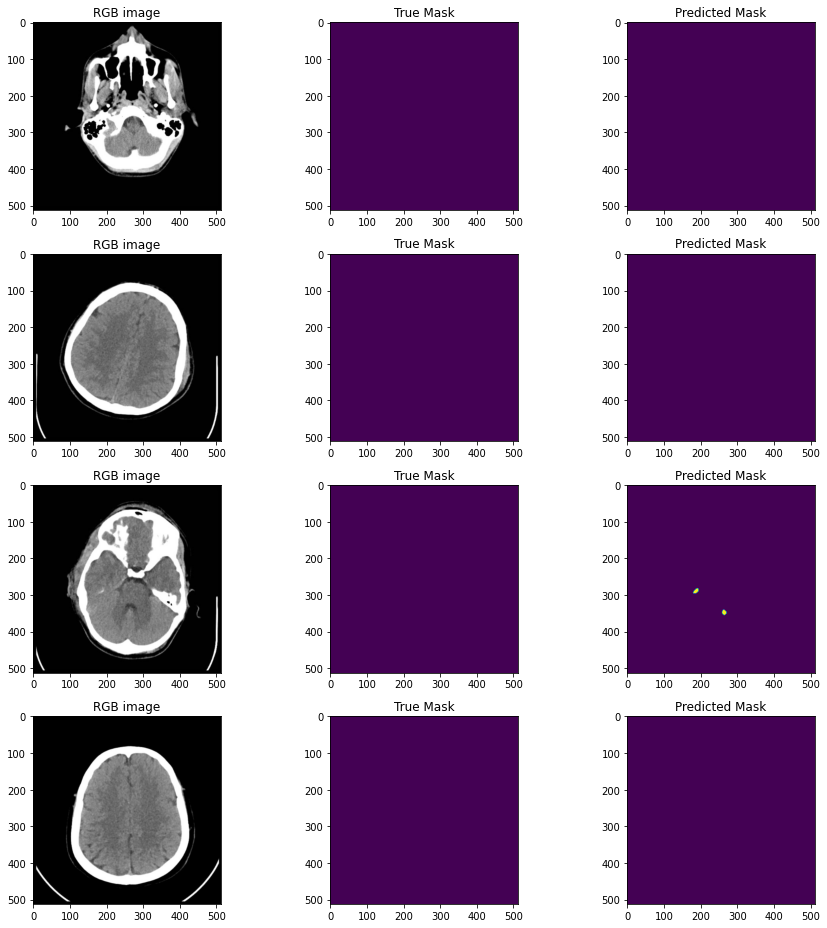

In [ ]:
# Plotting the predictions of the model

""" Using all images with no hemorrhages """

img_path_1 = "/content/drive/MyDrive/CT_SCANS_DATASET/test_images/065_5.jpg"
img_path_2 = "/content/drive/MyDrive/CT_SCANS_DATASET/test_images/083_25.jpg"

img_path_3 = "/content/drive/MyDrive/CT_SCANS_DATASET/test_images/089_15.jpg"
img_path_4 = "/content/drive/MyDrive/CT_SCANS_DATASET/test_images/102_24.jpg"

img_path_list = [img_path_1, img_path_2, img_path_3, img_path_4]

fig, axs = plt.subplots(nrows = 4, ncols = 3)

fig.set_figheight(13)
fig.set_figwidth(13)

for i in range(len(img_path_list)):

  # Image
  image_path = img_path_list[i]
  image = cv2.imread(image_path)
  image = image/255
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])

  axs[i][0].imshow(image)
  axs[i][0].set_title("RGB image")

  # True mask

  mask = tf.zeros((IMG_SIZE, IMG_SIZE))
  axs[i][1].imshow(mask)
  axs[i][1].set_title("True Mask")

  # Predicted Mask
  predict = model2.predict(tf.expand_dims(image, axis=0))
  predict = tf.cast((predict > 0.7), tf.float32)
  axs[i][2].imshow(tf.squeeze(tf.squeeze(predict, axis=-1), axis=0))
  axs[i][2].set_title("Predicted Mask")
  

plt.tight_layout()
plt.show()

#### Lets try and check the results from the attention layer in the later model

In [ ]:
att_model = tf.keras.Model(inputs = model2.input, outputs = model2.get_layer("attn_unet_up1_att_sigmoid").output)

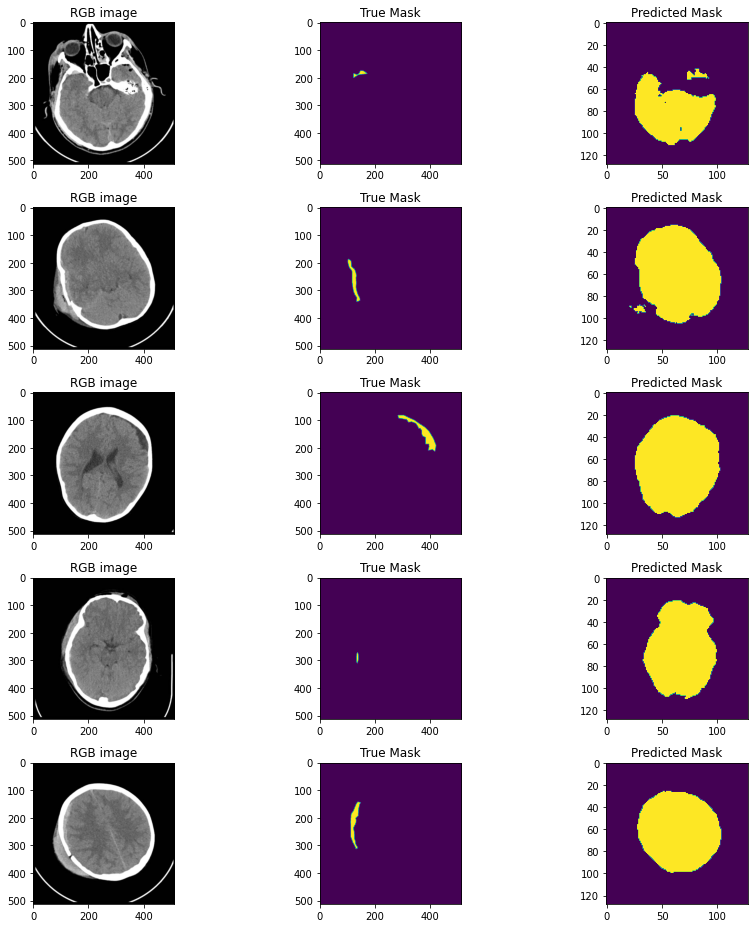

In [ ]:
# Plotting the predictions of attention coeff of the model

""" Using all images with hemorrhages """

mask_path_1 = "/content/drive/MyDrive/CT_SCANS_DATASET/test_masks/049_14_HGE_Seg.jpg"
mask_path_2 = "/content/drive/MyDrive/CT_SCANS_DATASET/test_masks/051_16_HGE_Seg.jpg"
mask_path_3 = "/content/drive/MyDrive/CT_SCANS_DATASET/test_masks/070_23_HGE_Seg.jpg"
mask_path_4 = "/content/drive/MyDrive/CT_SCANS_DATASET/test_masks/089_17_HGE_Seg.jpg"
mask_path_5 = "/content/drive/MyDrive/CT_SCANS_DATASET/test_masks/051_24_HGE_Seg.jpg"

mask_path_list = [mask_path_1, mask_path_2, mask_path_3, mask_path_4, mask_path_5]

fig, axs = plt.subplots(nrows = 5, ncols = 3)

fig.set_figheight(13)
fig.set_figwidth(13)

for i in range(len(mask_path_list)):

  # Image
  image_path = re.sub("test_masks", "test_images", mask_path_list[i])
  image_path = re.sub("_HGE_Seg", "", image_path)
  image = cv2.imread(image_path)
  image = image/255
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])

  axs[i][0].imshow(image)
  axs[i][0].set_title("RGB image")

  # True mask
  mask = tf.io.read_file(mask_path_list[i])
  mask = tf.image.decode_png(mask, channels=1)
  mask = tf.image.resize(mask, [IMG_SIZE, IMG_SIZE])
  mask = tf.squeeze(mask, axis=-1)
  mask = mask/255

  axs[i][1].imshow(mask)
  axs[i][1].set_title("True Mask")

  # Predicted Mask
  predict = att_model.predict(tf.expand_dims(image, axis=0))
  predict = tf.cast((predict > 0.7), tf.float32)

  axs[i][2].imshow(tf.squeeze(tf.squeeze(predict, axis=-1), axis=0))
  axs[i][2].set_title("Predicted Mask")
  

plt.tight_layout()
plt.show()

In [ ]:
from keras.models import load_model
model2 = load_model('/content/drive/MyDrive/brain_hemorrh_vgg16_backbone_2.hdf5', compile = False)

In [ ]:
cd /content

/content


In [ ]:
from tensorflow import lite

converter = lite.TFLiteConverter.from_keras_model(model2)
tfmodel = converter.convert()

open('model2.tflite', 'wb').write(tfmodel)

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tmp/tmp1q7c8ve_/assets


101163372